<a href="https://colab.research.google.com/github/rieldata1/deep-clustering-rails/blob/main/Deep_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Configurar GPU y activar high-RAM**

In [23]:
# Montar Drive
from google import colab
colab.drive.mount('/content/drive')
print("")

# Configurar GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# Activar high-RAM
import psutil
ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Tue Sep  2 20:39:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   49C    P0             28W /   72W |     761MiB /  23034MiB |      0%      Default |
|         

# **Deep_Clustering: carga NPZ + AE + K-sweep + DEC (+ IDEC)**
* Este notebook consumirá los NPZ generados por "Scalograms".


## **0. Preeliminares**

In [24]:
# ============================================================
#  PRELIMINARES: Parámetros + Imports + Runtime/Device + Utils
#  Este notebook consume los .npz generados por "Scalograms".
# ============================================================

# -----------------------------
# PARÁMETROS (ajusta aquí)
# -----------------------------
BASE_DIR           = "/content/drive/MyDrive/Deep_Cluster"
EXPERIMENTS_DIR    = f"{BASE_DIR}/experiments"

# Datos
PRELOAD_DATA       = True         # intentar precargar todos los .npz si caben en RAM
PRELOAD_MAX_GB     = 4.0          # umbral aprox para decidir precarga
IMG_NORMALIZE_AGAIN= False        # renormalizar [0,1] al vuelo (en general no hace falta)

# DataLoader
BATCH_AE           = 64
BATCH_EMB          = 128
BATCH_DEC          = 64
NUM_WORKERS        = 2
PIN_MEMORY         = True
PERSISTENT_WORKERS = True

# Modelo / Entrenamiento
LATENT_DIM         = 128
BACKBONE           = "base"       # 'small' | 'base' | 'large'
DROPOUT_P          = 0.0

AE_EPOCHS          = 25
AE_LR              = 1e-3
AE_WD              = 1e-5
AE_LOSS            = "l1"         # 'l1' o 'mse'
USE_AMP            = True         # mixed precision en GPU (dtype explícito)

# Barrido de K
K_MIN              = 2
K_MAX              = 10
K_FIXED            = None         # si lo fijas, salta el barrido (ej. 4)
K_RANDOM_STATE     = 2025

# DEC
DEC_EPOCHS         = 40
DEC_LR             = 1e-4
DEC_WD             = 0.0
DEC_UPDATE_INT     = 1
DEC_TOL            = 1e-3

# IDEC (opcional) — lo añadiremos en una celda siguiente si lo activas
RUN_IDEC           = False
IDEC_EPOCHS        = 40
IDEC_LR            = 1e-4
IDEC_WD            = 0.0
IDEC_LAMBDA_REC    = 1e-2
IDEC_UPDATE_INT    = 1
IDEC_TOL           = 1e-3

# Visualización / Guardado
RUN_TSNE_2D        = True
TSNE_PERPLEXITY    = 30
SEED               = 2025
SAVE_ARTIFACTS     = True

# -----------------------------
# IMPORTS
# -----------------------------
import os, time, csv, math, gc, json, random, glob, bisect
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from datetime import datetime
from collections import defaultdict, Counter
from tqdm import tqdm  # no 'auto' → evita widgets (GitHub render ok)

# Helper para KMeans sin FutureWarnings y compatible con varias versiones
def _kmeans(n_clusters, random_state=2025):
    """
    KMeans con n_init explícito:
    - si la versión soporta n_init="auto", lo usa (sin warning)
    - si no, cae a n_init=10 (compatibilidad hacia atrás)
    """
    try:
        return KMeans(n_clusters=n_clusters, n_init="auto", random_state=random_state)
    except TypeError:
        return KMeans(n_clusters=n_clusters, n_init=10, random_state=random_state)

# -----------------------------
# Runtime / Device
# -----------------------------
def seed_everything(seed=SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    if hasattr(torch, "set_float32_matmul_precision"):
        torch.set_float32_matmul_precision("high")

seed_everything(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Dispositivo:", torch.cuda.get_device_name(0) if DEVICE.type=="cuda" else "CPU")

os.makedirs(EXPERIMENTS_DIR, exist_ok=True)
RUN_DIR = os.path.join(EXPERIMENTS_DIR, datetime.now().strftime("run_%Y%m%d_%H%M%S"))
os.makedirs(RUN_DIR, exist_ok=True)
print("Carpeta de ejecución:", RUN_DIR)

# -----------------------------
# Utils
# -----------------------------
def sizeof_gb(n_items, h, w, bytes_per=2):
    """Tamaño estimado (GB) para n_items imágenes HxW en float{bytes_per}."""
    return (n_items * h * w * bytes_per) / (1024**3)

def count_params(m):
    """Parámetros entrenables del modelo."""
    return sum(p.numel() for p in m.parameters() if p.requires_grad)


✅ Dispositivo: NVIDIA L4
Carpeta de ejecución: /content/drive/MyDrive/Deep_Cluster/experiments/run_20250902_204444


## **1) Conjunto de datos**

[SCAN] .npz encontrados: 29
  • /content/drive/MyDrive/Deep_Cluster/data/scalos_train_000.npz
  • /content/drive/MyDrive/Deep_Cluster/data/scalos_train_001.npz
  • /content/drive/MyDrive/Deep_Cluster/data/scalos_train_002.npz
  • …
[MANIFEST] Ventanas=1800 | HxW=256x256
[MEM] ~0.22 GB | Preload=True (umbral=4.0 GB)
[LOAD] Precargando .npz a RAM…


Precarga: 100%|██████████| 29/29 [00:01<00:00, 15.19it/s]


[DATA] Train=1440 | Val=360 | Total=1800 | HxW=256x256


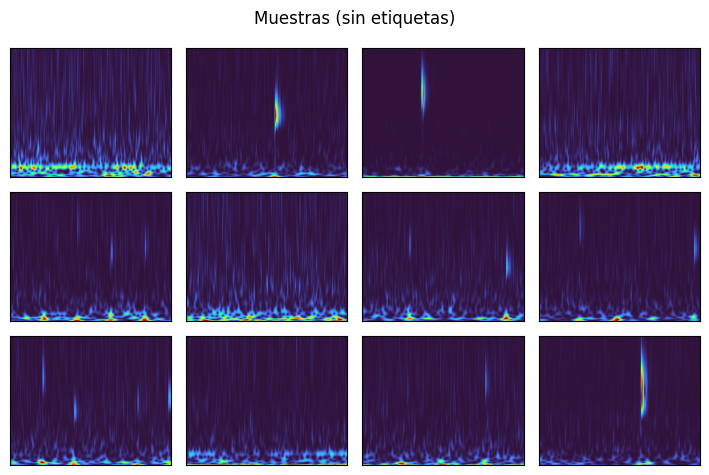

In [26]:
# ============================================================
# 1) DATASET (no supervisado): descubre .npz y carga escalogramas
# ============================================================
DATA_DIR = os.path.join(BASE_DIR, "data")
npz_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.npz")))
if not npz_files:
    raise FileNotFoundError(f"No hay .npz en {DATA_DIR}. ¿Ya corriste 'Scalograms'?")

print(f"[SCAN] .npz encontrados: {len(npz_files)}")
for p in npz_files[:3]: print("  •", p)
if len(npz_files) > 3: print("  • …")

class NPZManifest:
    """Escanea .npz → total de ventanas, HxW, y mapeo índice global → (archivo, índice local)."""
    def __init__(self, files):
        self.files = list(files)
        self.counts, self.cumcounts = [], [0]
        self.img_h = None; self.img_w = None
        for p in self.files:
            d = np.load(p, allow_pickle=True)
            X = d["X"]  # (B,H,W)
            B, H, W = X.shape
            self.counts.append(B)
            self.cumcounts.append(self.cumcounts[-1] + B)
            if self.img_h is None:
                self.img_h, self.img_w = int(H), int(W)
            else:
                if (self.img_h, self.img_w) != (int(H), int(W)):
                    raise ValueError(f"Tamaños inconsistentes: {p} {(H,W)} vs {(self.img_h,self.img_w)}")
        self.total = self.cumcounts[-1]

    def __len__(self): return self.total

    def locate(self, global_idx):
        file_idx = bisect.bisect_right(self.cumcounts, global_idx) - 1
        local_idx = global_idx - self.cumcounts[file_idx]
        return self.files[file_idx], int(local_idx)

manifest = NPZManifest(npz_files)
print(f"[MANIFEST] Ventanas={len(manifest)} | HxW={manifest.img_h}x{manifest.img_w}")

# Estimar si conviene precargar
est_gb = sizeof_gb(len(manifest), manifest.img_h, manifest.img_w, bytes_per=2)  # float16
do_preload = PRELOAD_DATA and (est_gb <= PRELOAD_MAX_GB + 1e-9)
print(f"[MEM] ~{est_gb:.2f} GB | Preload={do_preload} (umbral={PRELOAD_MAX_GB} GB)")

class ScalogramUnsupervisedDS(Dataset):
    """Devuelve (x, '_') con x → tensor (1,H,W) en [0,1]. Sin etiquetas."""
    def __init__(self, manifest: NPZManifest, preload=False, normalize_again=False):
        self.manifest = manifest
        self.normalize_again = normalize_again
        self.preload = preload
        self.cache = {}
        if self.preload:
            print("[LOAD] Precargando .npz a RAM…")
            for p in tqdm(self.manifest.files, desc="Precarga"):
                self.cache[p] = np.load(p, allow_pickle=True)["X"]  # (B,H,W) float16

    def __len__(self): return len(self.manifest)

    def __getitem__(self, i):
        p, j = self.manifest.locate(i)
        Xj = self.cache[p][j] if p in self.cache else np.load(p, allow_pickle=True)["X"][j]
        x = torch.from_numpy(np.asarray(Xj, dtype=np.float32)).unsqueeze(0)  # (1,H,W)
        if IMG_NORMALIZE_AGAIN:
            mn, mx = x.min(), x.max()
            x = (x - mn) / (mx - mn + 1e-12)
            x.clamp_(0.0, 1.0)
        return x, "_"  # placeholder sin etiquetas

# Instanciar dataset y splits 80/20
ds_all = ScalogramUnsupervisedDS(manifest, preload=do_preload, normalize_again=IMG_NORMALIZE_AGAIN)
rng = np.random.default_rng(SEED)
perm = rng.permutation(len(ds_all))
n_tr = int(0.8 * len(ds_all))
idx_tr, idx_va = perm[:n_tr], perm[n_tr:]

ds_train = Subset(ds_all, idx_tr)
ds_val   = Subset(ds_all, idx_va)

# DataLoaders
dl_train = DataLoader(ds_train, batch_size=BATCH_AE, shuffle=True,
                      num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                      persistent_workers=(NUM_WORKERS>0 and PERSISTENT_WORKERS),
                      drop_last=False)
dl_val   = DataLoader(ds_val, batch_size=BATCH_AE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                      persistent_workers=(NUM_WORKERS>0 and PERSISTENT_WORKERS),
                      drop_last=False)
def make_all_loader(ds, bs=BATCH_EMB):
    return DataLoader(ds, batch_size=bs, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                      persistent_workers=(NUM_WORKERS>0 and PERSISTENT_WORKERS),
                      drop_last=False)
dl_all = make_all_loader(ds_all, bs=BATCH_EMB)

print(f"[DATA] Train={len(ds_train)} | Val={len(ds_val)} | Total={len(ds_all)} | HxW={manifest.img_h}x{manifest.img_w}")

def show_grid_samples(dataset, n=12, rows=3, cols=4, title="Muestras (sin etiquetas)"):
    n = min(n, len(dataset), rows*cols)
    fig, axes = plt.subplots(rows, cols, figsize=(1.8*cols, 1.6*rows), sharex=True, sharey=True)
    axes = np.array(axes).reshape(-1)
    idxs = rng.choice(len(dataset), size=n, replace=False)
    for k, i in enumerate(idxs):
        x, _ = dataset[i]
        axes[k].imshow(x.squeeze(0).numpy(), origin="lower", aspect="auto", cmap="turbo")
        axes[k].set_xticks([]); axes[k].set_yticks([])
    for a in axes[n:]: a.axis("off")
    fig.suptitle(title); plt.tight_layout(); plt.show()
show_grid_samples(ds_all)


## **2) Modelo Autoencoder + Capa de Clustering**

In [27]:
# ============================================================
# 2) MODELO: Autoencoder conv + Capa de Clustering (Student-t)
# ============================================================

def make_channels(backbone: str):
    if backbone == "small": return [32, 64, 128, 256]
    if backbone == "large": return [64, 128, 256, 512]
    return [32, 64, 128, 256]  # 'base'

class ConvEncoder(nn.Module):
    def __init__(self, img_size, latent_dim=128, dropout_p=0.0, backbone="base"):
        super().__init__()
        C = make_channels(backbone)
        self.stem = nn.Sequential(
            nn.Conv2d(1,   C[0], 3, 2, 1), nn.BatchNorm2d(C[0]), nn.ReLU(inplace=True),
            nn.Conv2d(C[0],C[1], 3, 2, 1), nn.BatchNorm2d(C[1]), nn.ReLU(inplace=True),
            nn.Conv2d(C[1],C[2], 3, 2, 1), nn.BatchNorm2d(C[2]), nn.ReLU(inplace=True),
            nn.Conv2d(C[2],C[3], 3, 2, 1), nn.BatchNorm2d(C[3]), nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_p)
        )
        H, W = img_size
        with torch.no_grad():
            dummy = torch.zeros(1, 1, H, W)
            f = self.stem(dummy)  # (1, C[-1], H', W')
        self._feat_shape = f.shape
        c_last, h_last, w_last = f.shape[1], f.shape[2], f.shape[3]
        self.proj = nn.Linear(c_last * h_last * w_last, latent_dim)

    def forward(self, x):
        f = self.stem(x)
        z = self.proj(f.flatten(1))
        return z

class ConvDecoder(nn.Module):
    def __init__(self, feat_shape, latent_dim=128, dropout_p=0.0, backbone="base"):
        super().__init__()
        C = make_channels(backbone)
        c_last, h_last, w_last = feat_shape[1], feat_shape[2], feat_shape[3]
        self.fc = nn.Linear(latent_dim, c_last * h_last * w_last)
        self.head = nn.Sequential(
            nn.ConvTranspose2d(c_last, C[2], 4, 2, 1), nn.BatchNorm2d(C[2]), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(C[2], C[1], 4, 2, 1),   nn.BatchNorm2d(C[1]), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(C[1], C[0], 4, 2, 1),   nn.BatchNorm2d(C[0]), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(C[0], 1,     4, 2, 1),
            nn.Sigmoid()  # salida en [0,1]
        )
        self._feat_shape = (1, c_last, h_last, w_last)

    def forward(self, z):
        f = self.fc(z).view(z.size(0), *self._feat_shape[1:])
        xrec = self.head(f)
        return xrec

class ConvAutoencoder(nn.Module):
    def __init__(self, img_size, latent_dim=128, dropout_p=0.0, backbone="base"):
        super().__init__()
        self.encoder = ConvEncoder(img_size, latent_dim, dropout_p, backbone)
        self.decoder = ConvDecoder(self.encoder._feat_shape, latent_dim, dropout_p, backbone)
    def forward(self, x):
        z = self.encoder(x); xr = self.decoder(z); return z, xr

class ClusteringLayer(nn.Module):
    """Capa de clustering con kernel t-Student (DEC)."""
    def __init__(self, n_clusters, latent_dim, alpha=1.0):
        super().__init__()
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.cluster_centers = nn.Parameter(torch.randn(n_clusters, latent_dim))
    @torch.no_grad()
    def set_centers(self, centers_np):
        self.cluster_centers.copy_(torch.as_tensor(centers_np, dtype=torch.float32))
    def forward(self, z):
        z_exp  = z.unsqueeze(1)                        # (B,1,L)
        mu_exp = self.cluster_centers.unsqueeze(0)     # (1,K,L)
        dist2  = torch.sum((z_exp - mu_exp)**2, dim=2) # (B,K)
        num    = (1.0 + dist2 / self.alpha) ** (-(self.alpha + 1.0)/2.0)
        q      = num / torch.sum(num, dim=1, keepdim=True)
        return q

# Instanciar modelo y capa de clustering
IMG_H, IMG_W = manifest.img_h, manifest.img_w
ae = ConvAutoencoder(img_size=(IMG_H, IMG_W), latent_dim=LATENT_DIM,
                     dropout_p=DROPOUT_P, backbone=BACKBONE).to(DEVICE)
cluster_layer = ClusteringLayer(n_clusters=max(2, K_MIN), latent_dim=LATENT_DIM, alpha=1.0).to(DEVICE)

print(f"[MODEL] AE params: {count_params(ae):,} | Clustering params: {count_params(cluster_layer):,}")
xb, _ = next(iter(dl_train))
xb = xb.to(DEVICE, non_blocking=True)
with torch.no_grad():
    z, xr = ae(xb)
print(f"[CHECK] Batch: in {tuple(xb.shape)} → z {tuple(z.shape)} → recon {tuple(xr.shape)}")


[MODEL] AE params: 17,920,993 | Clustering params: 256
[CHECK] Batch: in (64, 1, 256, 256) → z (64, 128) → recon (64, 1, 256, 256)


## **3. Pre-entrenamiento del AutoEncoder + extracción de embeddings (Z)**

/tmp/ipython-input-3440562690.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device.type=="cuda"))
[AE][01/25] Train:   0%|          | 0/23 [00:00<?, ?it/s]/tmp/ipython-input-3440562690.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(use_amp and device.type=="cuda"), dtype=torch.float16):
[AE][01/25] Val  :   0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipython-input-3440562690.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(use_amp and device.type=="cuda"), dtype=torch.float16):


[AE] ep 01/25 | train=0.2766 | val=0.1324 | lr=1.00e-03 | 1.2s


[AE] ep 02/25 | train=0.1293 | val=0.0847 | lr=1.00e-03 | 1.1s


[AE] ep 03/25 | train=0.0779 | val=0.0530 | lr=1.00e-03 | 1.1s


[AE] ep 04/25 | train=0.0400 | val=0.0221 | lr=1.00e-03 | 1.1s


[AE] ep 05/25 | train=0.0205 | val=0.0177 | lr=1.00e-03 | 1.1s


[AE] ep 06/25 | train=0.0165 | val=0.0163 | lr=1.00e-03 | 1.1s


[AE] ep 07/25 | train=0.0154 | val=0.0155 | lr=1.00e-03 | 1.1s


[AE] ep 08/25 | train=0.0149 | val=0.0152 | lr=1.00e-03 | 1.1s


[AE] ep 09/25 | train=0.0145 | val=0.0149 | lr=1.00e-03 | 1.1s


[AE] ep 10/25 | train=0.0144 | val=0.0148 | lr=1.00e-03 | 1.1s


[AE] ep 11/25 | train=0.0142 | val=0.0146 | lr=1.00e-03 | 1.1s


[AE] ep 12/25 | train=0.0140 | val=0.0146 | lr=1.00e-03 | 1.1s


[AE] ep 13/25 | train=0.0139 | val=0.0144 | lr=1.00e-03 | 1.2s


[AE] ep 14/25 | train=0.0138 | val=0.0144 | lr=1.00e-03 | 1.1s


[AE] ep 15/25 | train=0.0137 | val=0.0143 | lr=1.00e-03 | 1.1s


[AE] ep 16/25 | train=0.0136 | val=0.0143 | lr=1.00e-03 | 1.1s


[AE] ep 17/25 | train=0.0136 | val=0.0153 | lr=1.00e-03 | 1.1s


[AE] ep 18/25 | train=0.0136 | val=0.0140 | lr=1.00e-03 | 1.1s


[AE] ep 19/25 | train=0.0133 | val=0.0138 | lr=1.00e-03 | 1.1s


[AE] ep 20/25 | train=0.0131 | val=0.0137 | lr=1.00e-03 | 1.1s


[AE] ep 21/25 | train=0.0130 | val=0.0135 | lr=1.00e-03 | 1.1s


[AE] ep 22/25 | train=0.0128 | val=0.0133 | lr=1.00e-03 | 1.1s


[AE] ep 23/25 | train=0.0127 | val=0.0134 | lr=1.00e-03 | 1.1s


[AE] ep 24/25 | train=0.0126 | val=0.0132 | lr=1.00e-03 | 1.1s


[AE] ep 25/25 | train=0.0125 | val=0.0132 | lr=1.00e-03 | 1.1s


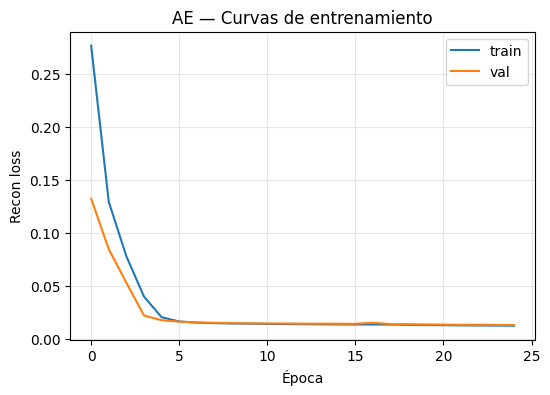

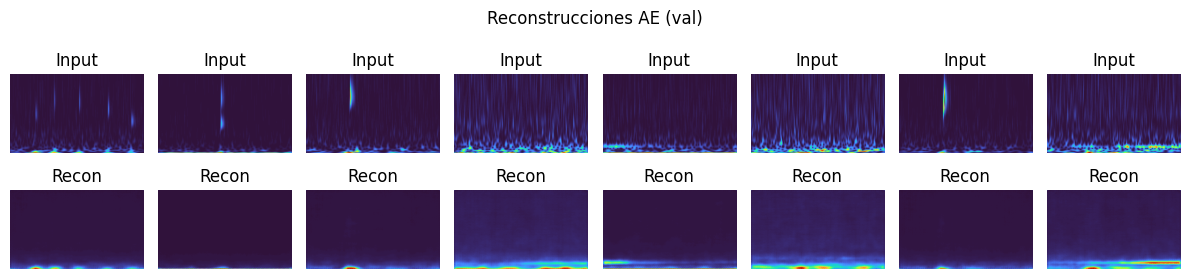

[Z] Extract:   0%|          | 0/15 [00:00<?, ?it/s]/tmp/ipython-input-3440562690.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(use_amp and device.type=="cuda"), dtype=torch.float16):
                                                            

Embeddings Z_all: (1800, 128)


In [28]:
# ============================================================
# 3) PREENTRENAMIENTO DEL AE (AMP) + EXTRACCIÓN DE Z (todo el set)
# ============================================================
def train_autoencoder(
    ae, dl_train, dl_val,
    epochs=AE_EPOCHS, lr=AE_LR, wd=AE_WD,
    use_amp=USE_AMP, loss_name=AE_LOSS, device=DEVICE,
):
    ae = ae.to(device).train()
    opt = torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=4)
    criterion = nn.MSELoss() if str(loss_name).lower()=="mse" else nn.L1Loss()
    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device.type=="cuda"))

    hist = {"train": [], "val": [], "lr": []}
    best_val, best_state = float("inf"), None

    for ep in range(1, epochs+1):
        t0 = time.time()
        # TRAIN
        ae.train(); tr_loss, ntr = 0.0, 0
        for xb, _ in tqdm(dl_train, desc=f"[AE][{ep:02d}/{epochs}] Train", leave=False):
            xb = xb.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(use_amp and device.type=="cuda"), dtype=torch.float16):
                z, xr = ae(xb)
                loss = criterion(xr, xb)
            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
            tr_loss += loss.item()*xb.size(0); ntr += xb.size(0)
        tr_loss /= max(1,ntr)

        # VAL
        ae.eval(); va_loss, nva = 0.0, 0
        with torch.no_grad():
            for xb, _ in tqdm(dl_val, desc=f"[AE][{ep:02d}/{epochs}] Val  ", leave=False):
                xb = xb.to(device, non_blocking=True)
                with torch.cuda.amp.autocast(enabled=(use_amp and device.type=="cuda"), dtype=torch.float16):
                    _, xr = ae(xb)
                    vl = criterion(xr, xb)
                va_loss += vl.item()*xb.size(0); nva += xb.size(0)
        va_loss /= max(1,nva)

        prev_lr = opt.param_groups[0]["lr"]
        scheduler.step(va_loss)
        lr_now = opt.param_groups[0]["lr"]
        if lr_now < prev_lr:
            print(f"   ↘ LR: {prev_lr:.2e} → {lr_now:.2e}")

        hist["train"].append(tr_loss); hist["val"].append(va_loss); hist["lr"].append(lr_now)
        print(f"[AE] ep {ep:02d}/{epochs} | train={tr_loss:.4f} | val={va_loss:.4f} | lr={lr_now:.2e} | {time.time()-t0:.1f}s")

        if va_loss < best_val - 1e-6:
            best_val = va_loss
            best_state = {k:v.detach().cpu().clone() for k,v in ae.state_dict().items()}
        torch.cuda.empty_cache(); gc.collect()

    if best_state is not None:
        ae.load_state_dict(best_state)
    return ae, hist

# Entrenar AE
ae, hist_ae = train_autoencoder(ae, dl_train, dl_val,
                                epochs=AE_EPOCHS, lr=AE_LR, wd=AE_WD,
                                use_amp=USE_AMP, loss_name=AE_LOSS, device=DEVICE)

# Curvas
plt.figure(figsize=(6,4))
plt.plot(hist_ae["train"], label="train")
plt.plot(hist_ae["val"], label="val")
plt.xlabel("Época"); plt.ylabel("Recon loss"); plt.title("AE — Curvas de entrenamiento")
plt.grid(alpha=0.3); plt.legend(); plt.show()

# Reconstrucciones rápidas
ae.eval()
with torch.no_grad():
    xb, _ = next(iter(dl_val))
    xb = xb.to(DEVICE, non_blocking=True)
    _, xr = ae(xb[:8])
xb = xb[:8].cpu().numpy(); xr = xr.cpu().numpy()

rows, cols = 2, min(8, xb.shape[0])
fig, axes = plt.subplots(rows, cols, figsize=(1.5*cols, 2.8))
for i in range(cols):
    axes[0, i].imshow(xb[i,0], origin="lower", aspect="auto", cmap="turbo"); axes[0, i].set_title("Input");  axes[0, i].axis("off")
    axes[1, i].imshow(xr[i,0], origin="lower", aspect="auto", cmap="turbo"); axes[1, i].set_title("Recon");  axes[1, i].axis("off")
plt.suptitle("Reconstrucciones AE (val)"); plt.tight_layout(); plt.show()

# Extracción de embeddings Z (todo el set)
@torch.no_grad()
def extract_embeddings(encoder, dl, device=DEVICE, use_amp=USE_AMP):
    encoder.eval(); Z_list = []
    for xb, _ in tqdm(dl, desc="[Z] Extract", leave=False):
        xb = xb.to(device, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=(use_amp and device.type=="cuda"), dtype=torch.float16):
            z = encoder(xb)
        Z_list.append(z.detach().cpu().numpy())
    return np.concatenate(Z_list, axis=0)

Z_all = extract_embeddings(ae.encoder, dl_all, device=DEVICE, use_amp=USE_AMP)
print("Embeddings Z_all:", Z_all.shape)
